# A/B Testing Masterclass: Product Experimentation
## Cookie Cats Mobile Game Analysis

---

### Learning Objectives

By the end of this notebook, you will understand:

1. **Sample Ratio Mismatch (SRM)** - Why randomization validation is critical
2. **Multiple Retention Metrics** - Testing 1-day and 7-day retention
3. **Multiple Testing Correction** - Benjamini-Hochberg FDR control
4. **Ratio Metrics** - Using the Delta method for engagement metrics
5. **Guardrail Framework** - Protecting critical metrics while optimizing
6. **Decision Making** - Ship/Hold/Abandon framework

---

### The Business Context

**Cookie Cats** is a popular mobile puzzle game. Like many mobile games, it uses "gates" - points where players must wait or pay to continue. These gates serve two purposes:

1. **Monetization** - Players can pay to skip the wait
2. **Engagement** - Breaks prevent burnout and bring players back

**The Experiment:**
- **Control (gate_30)**: Gate appears at level 30
- **Treatment (gate_40)**: Gate appears at level 40

**Hypothesis:** Moving the gate later will improve retention because players get more gameplay before hitting the "paywall", reducing early frustration.

**Risk:** Players who reach level 40 before hitting the gate might be more addicted, and the sudden stop could cause them to quit entirely.

---

## Setup and Data Loading

In [1]:
import os

if not os.getcwd().endswith("ab_testing"):
    try:
        os.chdir("../")
    except OSError:
        raise FileNotFoundError("Could not change into 'ab_testing' from the current directory.")

print(f"Current working directory: {os.getcwd()}")


Current working directory: c:\docker_projects\ab_testing


In [2]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# A/B Testing modules - we'll import these as we learn each concept
from ab_testing.data import loaders
from ab_testing.core import randomization, frequentist
from ab_testing.advanced import multiple_testing, ratio_metrics
from ab_testing.diagnostics import guardrails

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("✓ Modules loaded successfully")

✓ Modules loaded successfully


In [3]:
# Load the Cookie Cats dataset
df = loaders.load_cookie_cats(sample_frac=1.0)

print(f"Dataset loaded: {len(df):,} players")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Loading Cookie Cats dataset from data\raw\cookie_cats\cookie_cats.csv...
Loaded Cookie Cats dataset: 90,189 rows, 6 columns
  7-day retention (gate_30): 19.02%
  7-day retention (gate_40): 18.20%
Dataset loaded: 90,189 players

Columns: ['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7', 'treatment']

First few rows:


,userid,version,sum_gamerounds,retention_1,retention_7,treatment
0,116,gate_30,3,False,False,0
1,337,gate_30,38,True,False,0
2,377,gate_40,165,True,False,1
3,483,gate_40,1,False,False,1
4,488,gate_40,179,True,True,1


In [4]:
# Understand the data
print("Dataset Summary:")
print("=" * 50)
print(f"\nGroup distribution:")
print(df['version'].value_counts())
print(f"\n1-Day Retention by group:")
print(df.groupby('version')['retention_1'].mean())
print(f"\n7-Day Retention by group:")
print(df.groupby('version')['retention_7'].mean())
print(f"\nGame rounds statistics:")
print(df.groupby('version')['sum_gamerounds'].describe())

Dataset Summary:

Group distribution:
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

1-Day Retention by group:
version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

7-Day Retention by group:
version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Game rounds statistics:
           count       mean         std  min  25%   50%   75%      max
version                                                               
gate_30  44700.0  52.456264  256.716423  0.0  5.0  17.0  50.0  49854.0
gate_40  45489.0  51.298776  103.294416  0.0  5.0  16.0  52.0   2640.0


---

## Step 1: Sample Ratio Mismatch (SRM) Check

### Why SRM Matters

Before analyzing ANY results, we MUST verify that randomization worked correctly. SRM occurs when the actual group sizes don't match the expected allocation.

**Why is SRM critical?**

If groups are imbalanced beyond what random chance would produce, it indicates:
- **Bug in randomization code** - Assignment logic flawed
- **Tracking/logging issues** - Events lost for one group
- **Group-specific crashes** - Treatment causes technical problems
- **Bot traffic** - Concentrated in one group

**Industry Practice:**
- Microsoft: Blocks all analysis if SRM detected
- Netflix: Triggers immediate engineering alerts
- Booking.com: Uses even stricter alpha (0.001)

### Two-Stage SRM Gating

With large samples (90K+ users), even tiny deviations become statistically significant. We use a two-stage approach:

1. **Statistical Significance**: p-value < 0.01 (chi-square test)
2. **Practical Significance**: Deviation > 1 percentage point from expected

Only if BOTH conditions are met do we halt the analysis.

---

In [5]:
# Separate control and treatment groups
control = df[df['version'] == 'gate_30']
treatment = df[df['version'] == 'gate_40']

n_control = len(control)
n_treatment = len(treatment)
total = n_control + n_treatment

print("Group Sizes:")
print(f"  Control (gate_30):   {n_control:,} ({n_control/total:.2%})")
print(f"  Treatment (gate_40): {n_treatment:,} ({n_treatment/total:.2%})")
print(f"  Total:               {total:,}")

Group Sizes:
  Control (gate_30):   44,700 (49.56%)
  Treatment (gate_40): 45,489 (50.44%)
  Total:               90,189


In [6]:
# Run SRM check with two-stage gating
srm_result = randomization.srm_check(
    n_control=n_control,
    n_treatment=n_treatment,
    expected_ratio=[0.5, 0.5],  # Expected 50/50 split
    alpha=0.01,                  # Statistical threshold
    pp_threshold=0.01,           # 1 percentage point practical threshold
    count_threshold=None         # Not needed for large samples
)

print("SRM Check Results:")
print("=" * 50)
print(f"\nExpected: 50.00% / 50.00%")
print(f"Observed: {srm_result['ratio_control']:.2%} / {srm_result['ratio_treatment']:.2%}")
print(f"\nStatistical Test:")
print(f"  Chi-square statistic: {srm_result['chi2_statistic']:.4f}")
print(f"  P-value: {srm_result['p_value']:.6f}")
print(f"  Statistically significant (p < 0.01): {srm_result['srm_detected']}")
print(f"\nPractical Significance:")
print(f"  Max pp deviation: {srm_result['max_pp_deviation']:.4f}")
print(f"  Practically significant (> 1pp): {srm_result['practical_significant']}")
print(f"\nFinal Assessment:")
print(f"  SRM Severe (both conditions): {srm_result['srm_severe']}")
print(f"  SRM Warning (statistical only): {srm_result['srm_warning']}")

SRM Check Results:

Expected: 50.00% / 50.00%
Observed: 49.56% / 50.44%

Statistical Test:
  Chi-square statistic: 6.9024
  P-value: 0.008608
  Statistically significant (p < 0.01): True

Practical Significance:
  Max pp deviation: 0.0044
  Practically significant (> 1pp): False

Final Assessment:
  SRM Severe (both conditions): False
  SRM Warning (statistical only): True


### Understanding the SRM Result

**Interpreting our result:**

| Scenario | Statistical | Practical | Action |
|----------|------------|-----------|--------|
| Clean | No | No | ✓ Proceed with full confidence |
| Warning | Yes | No | ⚠️ Proceed with caution, monitor |
| Severe | Yes | Yes | ❌ STOP - investigate before proceeding |

With large samples, tiny deviations (0.1-0.5pp) can be statistically significant but practically irrelevant. This is why we use the two-stage approach.

---

In [7]:
# Decision gate - only proceed if SRM is not severe
if srm_result['srm_severe']:
    print("❌ ANALYSIS HALTED: Severe SRM failure detected")
    print("   Investigate randomization before proceeding.")
    # In production, you would exit here
else:
    if srm_result['srm_warning']:
        print("⚠️  SRM Warning: Statistical significance detected but deviation is small")
        print("   Proceeding with caution - monitor closely")
    else:
        print("✓ SRM Check PASSED")
        print("   Randomization valid - safe to proceed with analysis")

⚠️  SRM Warning: Statistical significance detected but deviation is small
   Proceeding with caution - monitor closely


---

## Step 2: Primary Metric Analysis (Retention Rates)

### Understanding Retention Metrics

Mobile games track retention at different time windows:

| Metric | Measures | Why It Matters |
|--------|----------|----------------|
| 1-Day Retention | Did they return after day 1? | Early engagement, first impression |
| 7-Day Retention | Did they return after day 7? | Sustained interest, habit formation |
| 30-Day Retention | Did they return after day 30? | Long-term engagement, lifetime value |

**Why both 1-day AND 7-day?**

A treatment could:
- Improve 1-day retention (less early frustration)
- Hurt 7-day retention (players quit when they finally hit the gate)

We need to test BOTH to understand the full picture.

### Z-Test for Proportions

Retention is a **binary metric** (came back: yes/no). We use a z-test for proportions:

$$z = \frac{\hat{p}_t - \hat{p}_c}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_t} + \frac{1}{n_c})}}$$

Where $\hat{p}$ is the pooled proportion.

---

In [8]:
# Calculate retention rates
retention_summary = pd.DataFrame({
    'Metric': ['1-Day Retention', '7-Day Retention'],
    'Control (gate_30)': [
        control['retention_1'].mean(),
        control['retention_7'].mean()
    ],
    'Treatment (gate_40)': [
        treatment['retention_1'].mean(),
        treatment['retention_7'].mean()
    ]
})

retention_summary['Lift'] = (
    retention_summary['Treatment (gate_40)'] / 
    retention_summary['Control (gate_30)'] - 1
) * 100

print("Retention Summary:")
print(retention_summary.to_string(index=False))

Retention Summary:
         Metric  Control (gate_30)  Treatment (gate_40)      Lift
1-Day Retention           0.448188             0.442283 -1.317566
7-Day Retention           0.190201             0.182000 -4.311903


In [9]:
# Test 1-Day Retention
retention_1d_result = frequentist.z_test_proportions(
    x_control=control['retention_1'].sum(),
    n_control=len(control),
    x_treatment=treatment['retention_1'].sum(),
    n_treatment=len(treatment),
    alpha=0.05,
    two_sided=True
)

print("1-Day Retention Test Results:")
print("=" * 50)
print(f"Control rate:   {control['retention_1'].mean():.4f} ({control['retention_1'].mean()*100:.2f}%)")
print(f"Treatment rate: {treatment['retention_1'].mean():.4f} ({treatment['retention_1'].mean()*100:.2f}%)")
print(f"\nAbsolute lift: {retention_1d_result['absolute_lift']:.4f} ({retention_1d_result['absolute_lift']*100:.2f}pp)")
print(f"Relative lift:  {retention_1d_result['relative_lift']:.2%}")
print(f"\nZ-statistic: {retention_1d_result['z_statistic']:.4f}")
print(f"P-value:     {retention_1d_result['p_value']:.6f}")
print(f"95% CI:      [{retention_1d_result['ci_lower']:.4f}, {retention_1d_result['ci_upper']:.4f}]")
print(f"\nSignificant (p < 0.05): {retention_1d_result['significant']}")

1-Day Retention Test Results:
Control rate:   0.4482 (44.82%)
Treatment rate: 0.4423 (44.23%)

Absolute lift: -0.0059 (-0.59pp)
Relative lift:  -1.32%

Z-statistic: -1.7841
P-value:     0.074410
95% CI:      [-0.0124, 0.0006]

Significant (p < 0.05): False


In [10]:
# Test 7-Day Retention
retention_7d_result = frequentist.z_test_proportions(
    x_control=control['retention_7'].sum(),
    n_control=len(control),
    x_treatment=treatment['retention_7'].sum(),
    n_treatment=len(treatment),
    alpha=0.05,
    two_sided=True
)

print("7-Day Retention Test Results:")
print("=" * 50)
print(f"Control rate:   {control['retention_7'].mean():.4f} ({control['retention_7'].mean()*100:.2f}%)")
print(f"Treatment rate: {treatment['retention_7'].mean():.4f} ({treatment['retention_7'].mean()*100:.2f}%)")
print(f"\nAbsolute lift: {retention_7d_result['absolute_lift']:.4f} ({retention_7d_result['absolute_lift']*100:.2f}pp)")
print(f"Relative lift:  {retention_7d_result['relative_lift']:.2%}")
print(f"\nZ-statistic: {retention_7d_result['z_statistic']:.4f}")
print(f"P-value:     {retention_7d_result['p_value']:.6f}")
print(f"95% CI:      [{retention_7d_result['ci_lower']:.4f}, {retention_7d_result['ci_upper']:.4f}]")
print(f"\nSignificant (p < 0.05): {retention_7d_result['significant']}")

7-Day Retention Test Results:
Control rate:   0.1902 (19.02%)
Treatment rate: 0.1820 (18.20%)

Absolute lift: -0.0082 (-0.82pp)
Relative lift:  -4.31%

Z-statistic: -3.1644
P-value:     0.001554
95% CI:      [-0.0133, -0.0031]

Significant (p < 0.05): True


### Visualizing the Results

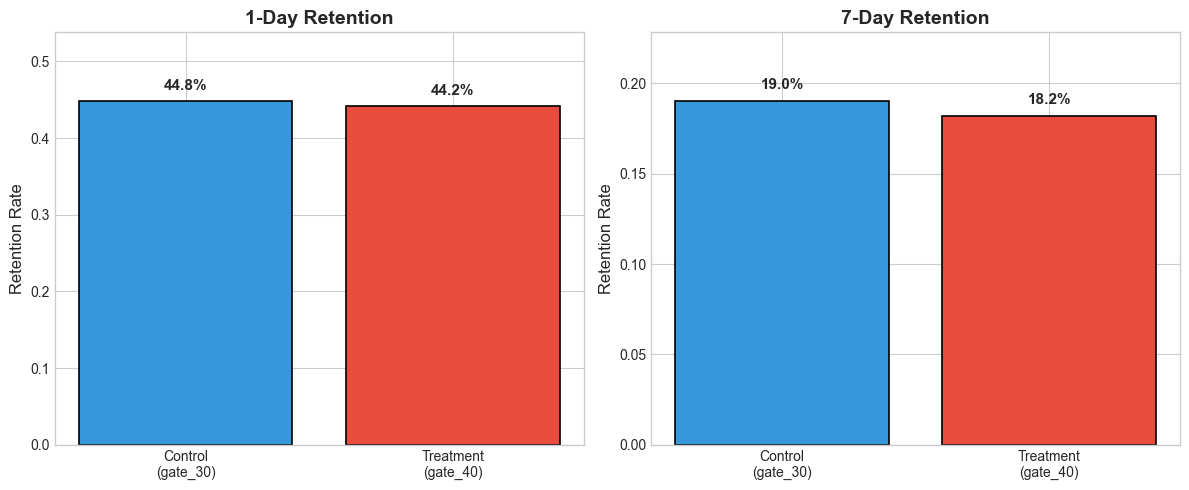

In [11]:
# Visualize retention comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1-Day Retention
ax1 = axes[0]
groups = ['Control\n(gate_30)', 'Treatment\n(gate_40)']
retention_1d_values = [control['retention_1'].mean(), treatment['retention_1'].mean()]
colors = ['#3498db', '#e74c3c']
bars1 = ax1.bar(groups, retention_1d_values, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Retention Rate', fontsize=12)
ax1.set_title('1-Day Retention', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(retention_1d_values) * 1.2)
for bar, val in zip(bars1, retention_1d_values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.1%}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 7-Day Retention
ax2 = axes[1]
retention_7d_values = [control['retention_7'].mean(), treatment['retention_7'].mean()]
bars2 = ax2.bar(groups, retention_7d_values, color=colors, edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Retention Rate', fontsize=12)
ax2.set_title('7-Day Retention', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(retention_7d_values) * 1.2)
for bar, val in zip(bars2, retention_7d_values):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.005, f'{val:.1%}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('data/graphs/retention_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Step 3: Multiple Testing Correction

### The Multiple Testing Problem

We just ran TWO statistical tests (1-day and 7-day retention). Each test has a 5% chance of a false positive. What's the probability of at least one false positive?

$$P(\text{at least 1 FP}) = 1 - (1 - \alpha)^n = 1 - 0.95^2 \approx 9.75\%$$

With more tests, this gets worse:

| Number of Tests | False Positive Rate |
|-----------------|--------------------|
| 1 | 5.0% |
| 2 | 9.8% |
| 5 | 22.6% |
| 10 | 40.1% |
| 20 | 64.2% |

### Correction Methods

| Method | Controls | Conservativeness | Use When |
|--------|----------|------------------|----------|
| **Bonferroni** | FWER | Very conservative | Critical decisions, >20 tests |
| **Benjamini-Hochberg** | FDR | Moderate | 2-20 tests, balance power/error |
| **Holm-Bonferroni** | FWER | Less conservative than Bonferroni | Alternative to Bonferroni |

**FWER** = Family-Wise Error Rate (probability of ANY false positive)  
**FDR** = False Discovery Rate (expected proportion of false positives among rejections)

### Benjamini-Hochberg Procedure

1. Rank p-values from smallest to largest
2. For each p-value: adjusted_p = p × (n / rank)
3. Ensure monotonicity (adjust downward if needed)
4. Reject if adjusted_p < α

---

In [12]:
# Collect p-values from both tests
p_values = [
    retention_1d_result['p_value'],
    retention_7d_result['p_value']
]
metric_names = ['1-Day Retention', '7-Day Retention']

print("Before Multiple Testing Correction:")
print("=" * 50)
for name, p in zip(metric_names, p_values):
    sig = "✓ Significant" if p < 0.05 else "○ Not significant"
    print(f"  {name}: p = {p:.6f} {sig}")
print(f"\nTotal tests: {len(p_values)}")
print(f"Uncorrected FWER: {1 - (1-0.05)**len(p_values):.1%}")

Before Multiple Testing Correction:
  1-Day Retention: p = 0.074410 ○ Not significant
  7-Day Retention: p = 0.001554 ✓ Significant

Total tests: 2
Uncorrected FWER: 9.8%


In [13]:
# Apply Benjamini-Hochberg correction
bh_result = multiple_testing.benjamini_hochberg(
    p_values=p_values,
    alpha=0.05
)

print("After Benjamini-Hochberg Correction:")
print("=" * 50)
print(f"Method: Benjamini-Hochberg (FDR control)")
print(f"Original alpha: 0.05")
print(f"\nResults:")
for i, (name, orig_p, adj_p, sig) in enumerate(zip(
    metric_names,
    p_values,
    bh_result['adjusted_p_values'],
    bh_result['significant']
)):
    status = "✓ Significant" if sig else "○ Not significant"
    print(f"  {name}:")
    print(f"    Original p-value: {orig_p:.6f}")
    print(f"    Adjusted p-value: {adj_p:.6f}")
    print(f"    After correction: {status}")

print(f"\nSummary:")
n_sig_before = sum(p < 0.05 for p in p_values)
n_sig_after = sum(bh_result['significant'])
print(f"  Significant before correction: {n_sig_before}/{len(p_values)}")
print(f"  Significant after correction:  {n_sig_after}/{len(p_values)}")

After Benjamini-Hochberg Correction:
Method: Benjamini-Hochberg (FDR control)
Original alpha: 0.05

Results:
  1-Day Retention:
    Original p-value: 0.074410
    Adjusted p-value: 0.074410
    After correction: ○ Not significant
  7-Day Retention:
    Original p-value: 0.001554
    Adjusted p-value: 0.003108
    After correction: ✓ Significant

Summary:
  Significant before correction: 1/2
  Significant after correction:  1/2


### Why This Matters in Practice

**Scenario 1:** Both metrics significant after correction
- Strong evidence of real effect
- High confidence in conclusions

**Scenario 2:** One metric loses significance after correction
- Original "significance" may have been a false positive
- Be cautious about claiming effect on that metric

**Industry Practice:**
- LinkedIn: Uses B-H for metric suites (5-10 metrics)
- Facebook: Adjusts for primary metrics, not secondary/exploratory
- Spotify: Pre-declares primary metrics (no correction needed)
- Netflix: Conservative approach - corrects for all concurrent metrics

---

---

## Step 4: Ratio Metrics Analysis (Engagement)

### What is a Ratio Metric?

Many important metrics are ratios:
- **CTR** = clicks / impressions
- **ARPU** = revenue / users
- **Engagement Rate** = interactions / sessions
- **Game Rounds per Player** = total_rounds / players

### Why Special Handling?

Ratio metrics have a complex variance structure. A naive approach (testing numerator and denominator separately) gives wrong answers because:

1. Numerator and denominator are correlated
2. Small changes in denominator can amplify ratio changes
3. Standard error formulas don't apply directly

### The Delta Method

The **Delta Method** provides correct confidence intervals for ratios:

$$\text{Var}\left(\frac{X}{Y}\right) \approx \left(\frac{\mu_X}{\mu_Y}\right)^2 \left[\frac{\text{Var}(X)}{\mu_X^2} + \frac{\text{Var}(Y)}{\mu_Y^2} - \frac{2\text{Cov}(X,Y)}{\mu_X \mu_Y}\right]$$

For our engagement metric (game rounds per player), Y = 1 per player, so it simplifies.

---

In [14]:
# Analyze engagement: game rounds per player
control_rounds = control['sum_gamerounds'].values
treatment_rounds = treatment['sum_gamerounds'].values

print("Engagement Metric: Game Rounds per Player")
print("=" * 50)
print(f"\nControl (gate_30):")
print(f"  Mean: {control_rounds.mean():.2f} rounds/player")
print(f"  Std:  {control_rounds.std():.2f}")
print(f"  Median: {np.median(control_rounds):.2f}")

print(f"\nTreatment (gate_40):")
print(f"  Mean: {treatment_rounds.mean():.2f} rounds/player")
print(f"  Std:  {treatment_rounds.std():.2f}")
print(f"  Median: {np.median(treatment_rounds):.2f}")

print(f"\nDifference:")
print(f"  Absolute: {treatment_rounds.mean() - control_rounds.mean():.2f} rounds")
print(f"  Relative: {(treatment_rounds.mean()/control_rounds.mean() - 1)*100:.2f}%")

Engagement Metric: Game Rounds per Player

Control (gate_30):
  Mean: 52.46 rounds/player
  Std:  256.71
  Median: 17.00

Treatment (gate_40):
  Mean: 51.30 rounds/player
  Std:  103.29
  Median: 16.00

Difference:
  Absolute: -1.16 rounds
  Relative: -2.21%


In [15]:
# Apply Delta method for ratio metric test
engagement_result = ratio_metrics.ratio_metric_test(
    numerator_control=control_rounds,
    denominator_control=np.ones(len(control)),  # 1 player = 1 denominator unit
    numerator_treatment=treatment_rounds,
    denominator_treatment=np.ones(len(treatment)),
    alpha=0.05
)

print("Delta Method Test Results:")
print("=" * 50)
print(f"\nControl mean:    {control_rounds.mean():.2f} rounds/player")
print(f"Treatment mean:  {treatment_rounds.mean():.2f} rounds/player")
print(f"\nAbsolute difference: {engagement_result['ratio_diff']:.2f} rounds")
print(f"Relative change:     {engagement_result['relative_lift']:.2%}")
print(f"\nStandard error: {engagement_result.get('se', 0.0):.4f}")
print(f"Z-statistic:    {engagement_result.get('z_statistic', 0.0):.4f}")
print(f"P-value:        {engagement_result['p_value']:.6f}")
print(f"95% CI:         [{engagement_result['ci_lower']:.2f}, {engagement_result['ci_upper']:.2f}]")
print(f"\nSignificant: {engagement_result['significant']}")

Delta Method Test Results:

Control mean:    52.46 rounds/player
Treatment mean:  51.30 rounds/player

Absolute difference: -1.16 rounds
Relative change:     -2.21%

Standard error: 0.0000
Z-statistic:    -0.8854
P-value:        0.375921
95% CI:         [-3.72, 1.40]

Significant: False


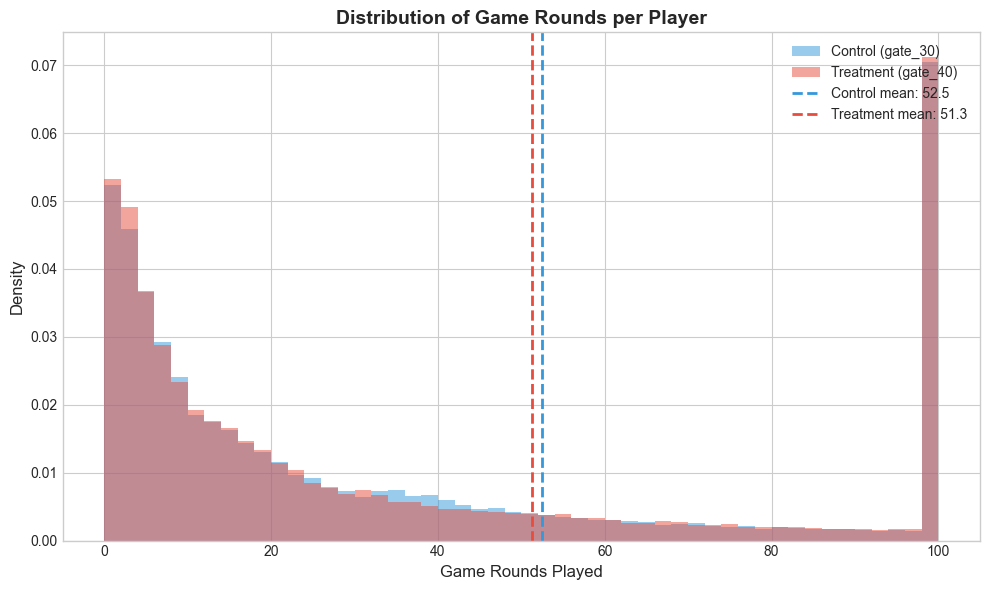

In [16]:
# Visualize engagement distribution
fig, ax = plt.subplots(figsize=(10, 6))

# Cap at 100 rounds for visualization (outliers exist)
max_rounds = 100
control_capped = np.clip(control_rounds, 0, max_rounds)
treatment_capped = np.clip(treatment_rounds, 0, max_rounds)

ax.hist(control_capped, bins=50, alpha=0.5, label='Control (gate_30)', color='#3498db', density=True)
ax.hist(treatment_capped, bins=50, alpha=0.5, label='Treatment (gate_40)', color='#e74c3c', density=True)

ax.axvline(control_rounds.mean(), color='#3498db', linestyle='--', linewidth=2, label=f'Control mean: {control_rounds.mean():.1f}')
ax.axvline(treatment_rounds.mean(), color='#e74c3c', linestyle='--', linewidth=2, label=f'Treatment mean: {treatment_rounds.mean():.1f}')

ax.set_xlabel('Game Rounds Played', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution of Game Rounds per Player', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('data/graphs/engagement_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Step 5: Guardrail Metrics and Decision Framework

### Primary vs Guardrail Metrics

| Type | Purpose | Example | Testing Approach |
|------|---------|---------|------------------|
| **Primary** | What we're trying to IMPROVE | 1-day retention | Standard hypothesis test |
| **Guardrail** | What we must NOT HARM | 7-day retention, engagement | Non-inferiority test |

### Non-Inferiority Testing

For guardrails, we don't ask "is it better?" We ask "is it not too much worse?"

- Set a **tolerance threshold** (e.g., allow up to -1% degradation)
- Test: Is the lower bound of CI above the threshold?
- If yes: Guardrail PASSED
- If no: Guardrail FAILED (unacceptable risk of harm)

### Our Framework

| Metric | Role | Tolerance |
|--------|------|----------|
| 1-Day Retention | **Primary** | Want improvement |
| 7-Day Retention | Guardrail | Allow up to -1% degradation |
| Engagement (rounds) | Guardrail | Allow up to -5% degradation |

---

In [17]:
# Guardrail 1: 7-Day Retention (must not degrade more than 1%)
guardrail_retention_7d = guardrails.non_inferiority_test(
    control=control['retention_7'].values.astype(float),
    treatment=treatment['retention_7'].values.astype(float),
    delta=-0.01,  # Allow max 1% relative degradation
    metric_type='relative',
    alpha=0.05
)
guardrail_retention_7d['metric_name'] = '7-Day Retention'

print("Guardrail 1: 7-Day Retention")
print("=" * 50)
print(f"Tolerance: -1.0% (max allowed degradation)")
print(f"\nControl mean:   {guardrail_retention_7d['mean_control']:.4f}")
print(f"Treatment mean: {guardrail_retention_7d['mean_treatment']:.4f}")

# Calculate relative change for display
rel_change_7d = guardrail_retention_7d['difference'] / guardrail_retention_7d['mean_control']
rel_ci_lower_7d = guardrail_retention_7d['ci_lower'] / guardrail_retention_7d['mean_control']

print(f"\nRelative change:    {rel_change_7d:.2%}")
print(f"95% CI lower bound: {rel_ci_lower_7d:.2%}")
print(f"\nResult: {'✓ PASSED' if guardrail_retention_7d['passed'] else '✗ FAILED'}")

Guardrail 1: 7-Day Retention
Tolerance: -1.0% (max allowed degradation)

Control mean:   0.1902
Treatment mean: 0.1820

Relative change:    -4.31%
95% CI lower bound: -6.55%

Result: ✗ FAILED


In [18]:
# Guardrail 2: Engagement (must not degrade more than 5%)
guardrail_engagement = guardrails.non_inferiority_test(
    control=control_rounds,
    treatment=treatment_rounds,
    delta=-0.05,  # Allow max 5% degradation
    metric_type='relative',
    alpha=0.05
)
guardrail_engagement['metric_name'] = 'Engagement (Game Rounds)'

print("Guardrail 2: Engagement (Game Rounds per Player)")
print("=" * 50)
print(f"Tolerance: -5.0% (max allowed degradation)")
print(f"\nControl mean:   {guardrail_engagement['mean_control']:.2f} rounds")
print(f"Treatment mean: {guardrail_engagement['mean_treatment']:.2f} rounds")

# Calculate relative change for display
rel_change_eng = guardrail_engagement['difference'] / guardrail_engagement['mean_control']
rel_ci_lower_eng = guardrail_engagement['ci_lower'] / guardrail_engagement['mean_control']

print(f"\nRelative change:    {rel_change_eng:.2%}")
print(f"95% CI lower bound: {rel_ci_lower_eng:.2%}")
print(f"\nResult: {'✓ PASSED' if guardrail_engagement['passed'] else '✗ FAILED'}")

Guardrail 2: Engagement (Game Rounds per Player)
Tolerance: -5.0% (max allowed degradation)

Control mean:   52.46 rounds
Treatment mean: 51.30 rounds

Relative change:    -2.21%
95% CI lower bound: -6.31%

Result: ✗ FAILED


In [19]:
# Make final decision using the framework
decision_result = guardrails.evaluate_guardrails(
    primary_result=retention_1d_result,
    guardrail_results=[guardrail_retention_7d, guardrail_engagement]
)

print("\n" + "=" * 60)
print("DECISION FRAMEWORK EVALUATION")
print("=" * 60)
print(f"\n🎯 Primary Metric: 1-Day Retention")
print(f"   Significant: {decision_result['primary_significant']}")
print(f"   Positive:    {decision_result['primary_positive']}")
print(f"   Lift:        {retention_1d_result['relative_lift']:.2%}")

print(f"\n🛡️  Guardrail Metrics:")
print(f"   Passed: {decision_result['guardrails_passed']} / {decision_result['guardrails_total']}")
print(f"   - 7-Day Retention: {'✓ PASSED' if guardrail_retention_7d['passed'] else '✗ FAILED'}")
print(f"   - Engagement:      {'✓ PASSED' if guardrail_engagement['passed'] else '✗ FAILED'}")

print(f"\n" + "=" * 60)
decision = decision_result['decision'].upper()
print(f">>> FINAL DECISION: {decision} <<<")
print("=" * 60)


DECISION FRAMEWORK EVALUATION

🎯 Primary Metric: 1-Day Retention
   Significant: False
   Positive:    False
   Lift:        -1.32%

🛡️  Guardrail Metrics:
   Passed: 0 / 2
   - 7-Day Retention: ✗ FAILED
   - Engagement:      ✗ FAILED

>>> FINAL DECISION: HOLD <<<


---

## Step 6: Interpreting the Decision

### Decision Logic

In [20]:
# Explain the decision
decision = decision_result['decision'].upper()

print("\n" + "=" * 60)
print("DECISION INTERPRETATION")
print("=" * 60)

if decision == 'SHIP':
    print("\n✅ SHIP RECOMMENDATION")
    print("\nWhy ship?")
    print(f"  • Primary metric (1-day retention) improved by {retention_1d_result['relative_lift']:.2%}")
    print(f"  • All {decision_result['guardrails_total']} guardrails passed")
    print(f"  • No unacceptable harm to critical metrics")
    print("\nBusiness impact:")
    print(f"  • For every 100,000 new players:")
    print(f"    - Additional day-1 returns: {abs(retention_1d_result['absolute_lift']) * 100000:.0f} players")
    print(f"  • Larger engaged base → more monetization opportunities")
    print("\nNext steps:")
    print("  1. Roll out to 100% of players")
    print("  2. Monitor 7-day and 30-day retention post-launch")
    print("  3. Track revenue impact (validate monetization hypothesis)")

elif decision == 'ABANDON':
    print("\n❌ ABANDON RECOMMENDATION")
    print("\nWhy abandon?")
    if not decision_result['primary_positive']:
        print(f"  • Primary metric showed NEGATIVE impact")
    if not guardrail_retention_7d['passed']:
        print(f"  • 7-day retention guardrail FAILED")
    if not guardrail_engagement['passed']:
        print(f"  • Engagement guardrail FAILED")
    print("\nPossible reasons for failure:")
    print("  • Gate too late: Players quit when they finally hit it")
    print("  • Levels 31-40 too hard without paid boosts")
    print("  • Players don't value IAP until after gate experience")
    print("\nNext steps:")
    print("  1. Analyze user feedback and qualitative data")
    print("  2. Consider alternative gate positions (level 35?)")
    print("  3. Test with refined design addressing root cause")

else:  # HOLD
    print("\n⚪ HOLD RECOMMENDATION")
    print("\nWhy hold?")
    if not decision_result['primary_significant']:
        print(f"  • Primary metric not statistically significant")
        print(f"  • Observed {retention_1d_result['relative_lift']:.2%} lift could be random noise")
    if decision_result['guardrails_passed'] < decision_result['guardrails_total']:
        print(f"  • {decision_result['guardrails_total'] - decision_result['guardrails_passed']} guardrail(s) have concerning results")
    print("\nOptions:")
    print("  1. Extend experiment duration (more data)")
    print("  2. Increase traffic allocation (faster data)")
    print("  3. Analyze subgroups (new vs existing players)")


DECISION INTERPRETATION

⚪ HOLD RECOMMENDATION

Why hold?
  • Primary metric not statistically significant
  • Observed -1.32% lift could be random noise
  • 2 guardrail(s) have concerning results

Options:
  1. Extend experiment duration (more data)
  2. Increase traffic allocation (faster data)
  3. Analyze subgroups (new vs existing players)


---

## Summary and Key Learnings

### What We Covered

1. **SRM Check (Sample Ratio Mismatch)**
   - Always validate randomization BEFORE analyzing results
   - Use two-stage gating for large samples (statistical + practical)
   - If severe SRM detected: STOP and investigate

2. **Multiple Retention Metrics**
   - Test multiple time windows to understand full effect
   - 1-day: immediate impact, 7-day: sustained engagement
   - Different metrics can show different (even opposite) effects

3. **Multiple Testing Correction**
   - Testing N metrics inflates false positive rate
   - Benjamini-Hochberg: Good balance of power and error control
   - Apply to all metrics or pre-declare primaries

4. **Ratio Metrics (Delta Method)**
   - CTR, ARPU, engagement rates need special handling
   - Delta method provides correct confidence intervals
   - Never test numerator and denominator separately

5. **Guardrail Framework**
   - Primary metrics: What we optimize (want improvement)
   - Guardrails: What we protect (must not harm beyond threshold)
   - Non-inferiority testing for guardrails

6. **Decision Framework**
   - SHIP: Primary significant + positive, all guardrails pass
   - ABANDON: Negative effect or guardrail failure
   - HOLD: Inconclusive, need more evidence

### Industry Best Practices

- **Zynga**: Tests all monetization changes with retention guardrails
- **King**: Typical tolerances: -2% revenue, -1% retention
- **Supercell**: Runs 2-4 week tests for feature changes (novelty effects)
- **Playrix**: Segments by player lifetime (new vs whale vs churned)

### Applying to Your Experiments

1. **Define upfront:**
   - Primary metric (what you're optimizing)
   - Guardrail metrics with tolerances
   - Expected effect size for power calculation

2. **During experiment:**
   - Check SRM regularly
   - Don't peek at p-values (or use sequential testing)

3. **At analysis:**
   - Apply multiple testing correction if >1 primary metric
   - Use appropriate test for each metric type
   - Document decision and reasoning

---

## Exercises

### Exercise 1: Vary the Guardrail Thresholds

What happens if you make the guardrails stricter (-0.5% instead of -1%)? Does the decision change?

In [21]:
# YOUR CODE HERE
# Try running non_inferiority_test with delta=-0.005 (0.5%)


### Exercise 2: Use Bonferroni Instead of Benjamini-Hochberg

Compare the adjusted p-values with Bonferroni correction. Which is more conservative?

In [22]:
# YOUR CODE HERE
# bonf_result = multiple_testing.bonferroni(p_values=p_values, alpha=0.05)


### Exercise 3: Analyze by User Segment

If the dataset had user segments (e.g., new users vs returning users), how would you analyze each segment separately? What would you look for?

In [23]:
# YOUR THOUGHTS HERE
# Hint: Think about heterogeneous treatment effects
